# Weapons of Math Instruction - WiFi

In this notebook, we will demonstrate the pattern of life fingerprint and machine learning methodology to classify a WAP as transient or stationary.

# Data Preperation

In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA

Then, we pull the data in

In [2]:
df = pd.read_csv("../data/Clean_wap_log_20190613.csv", float_precision='high')
df.head()

,Unnamed: 0,RSSI,CHANNEL,SENSOR,EPOCH,OUI,HASH,CO
0,0,0,1,Pi3B,1.559696e+09,B0:B9:8A,0af6b9c7ccb0ca7105303b3cad7ec22f,Netgear
1,1,0,1,Pi3B,1.559696e+09,4C:01:43,172b5824dbe65036406783398672bf7a,Eero
2,2,0,1,Pi3B,1.559696e+09,94:8F:CF,ac31484895c5705d38fc292605778dbc,ArrisGro
3,3,0,1,Pi3B,1.559696e+09,0C:EA:C9,eab56c71ae77fae1653f486aa3b3a93b,ArrisGro
4,4,0,1,Pi3B,1.559696e+09,88:96:4E,f4b963655e9bf59f89dcc09396468861,ArrisGro


Enrich the data frame by breaking out the epoch time into month, day, hour, sec and minute of the day attributes

In [3]:
#time.strftime('%m,%d,%H,%M,%S', time.localtime(df['EPOCH'][0])).split(',')
date = [time.strftime('%m,%d,%H,%M,%S', time.localtime(x)).split(',') for x in df["EPOCH"]]
df["MONTH"] = [int(x[0]) for x in date]
df["DAY"] = [int(x[1]) for x in date]
df["HOUR"] = [int(x[2]) for x in date]
df["MIN"] = [int(x[3]) for x in date]
df["SEC"] = [int(x[4]) for x in date]
df["MIN_OF_DAY"] = [int(x[2]) * 60 + int(x[2]) for x in date]
df.head()

,Unnamed: 0,RSSI,CHANNEL,SENSOR,EPOCH,OUI,HASH,CO,MONTH,DAY,HOUR,MIN,SEC,MIN_OF_DAY
0,0,0,1,Pi3B,1.559696e+09,B0:B9:8A,0af6b9c7ccb0ca7105303b3cad7ec22f,Netgear,6,4,20,46,50,1220
1,1,0,1,Pi3B,1.559696e+09,4C:01:43,172b5824dbe65036406783398672bf7a,Eero,6,4,20,46,50,1220
2,2,0,1,Pi3B,1.559696e+09,94:8F:CF,ac31484895c5705d38fc292605778dbc,ArrisGro,6,4,20,46,50,1220
3,3,0,1,Pi3B,1.559696e+09,0C:EA:C9,eab56c71ae77fae1653f486aa3b3a93b,ArrisGro,6,4,20,46,50,1220
4,4,0,1,Pi3B,1.559696e+09,88:96:4E,f4b963655e9bf59f89dcc09396468861,ArrisGro,6,4,20,46,50,1220


# Exploratory Analysis 

Start analysis by looking at the SSID names observed. We have 191 unique SSIDs in this data set across 194 unique MAC addresses. Due to the way we hashed the combination of the two fields, we have 228 unique hashes

In [4]:
unique_hashes = df['HASH'].unique()
print("Number of unique SSID+MAC md5 hash: {}".format(len(unique_hashes)))

Number of unique SSID+MAC md5 hash: 152


# Examining how talkative each WAP is
Look at the number of times we see each Hash. We can see that several have large amounts of traffic, but most have very small amounts of traffic

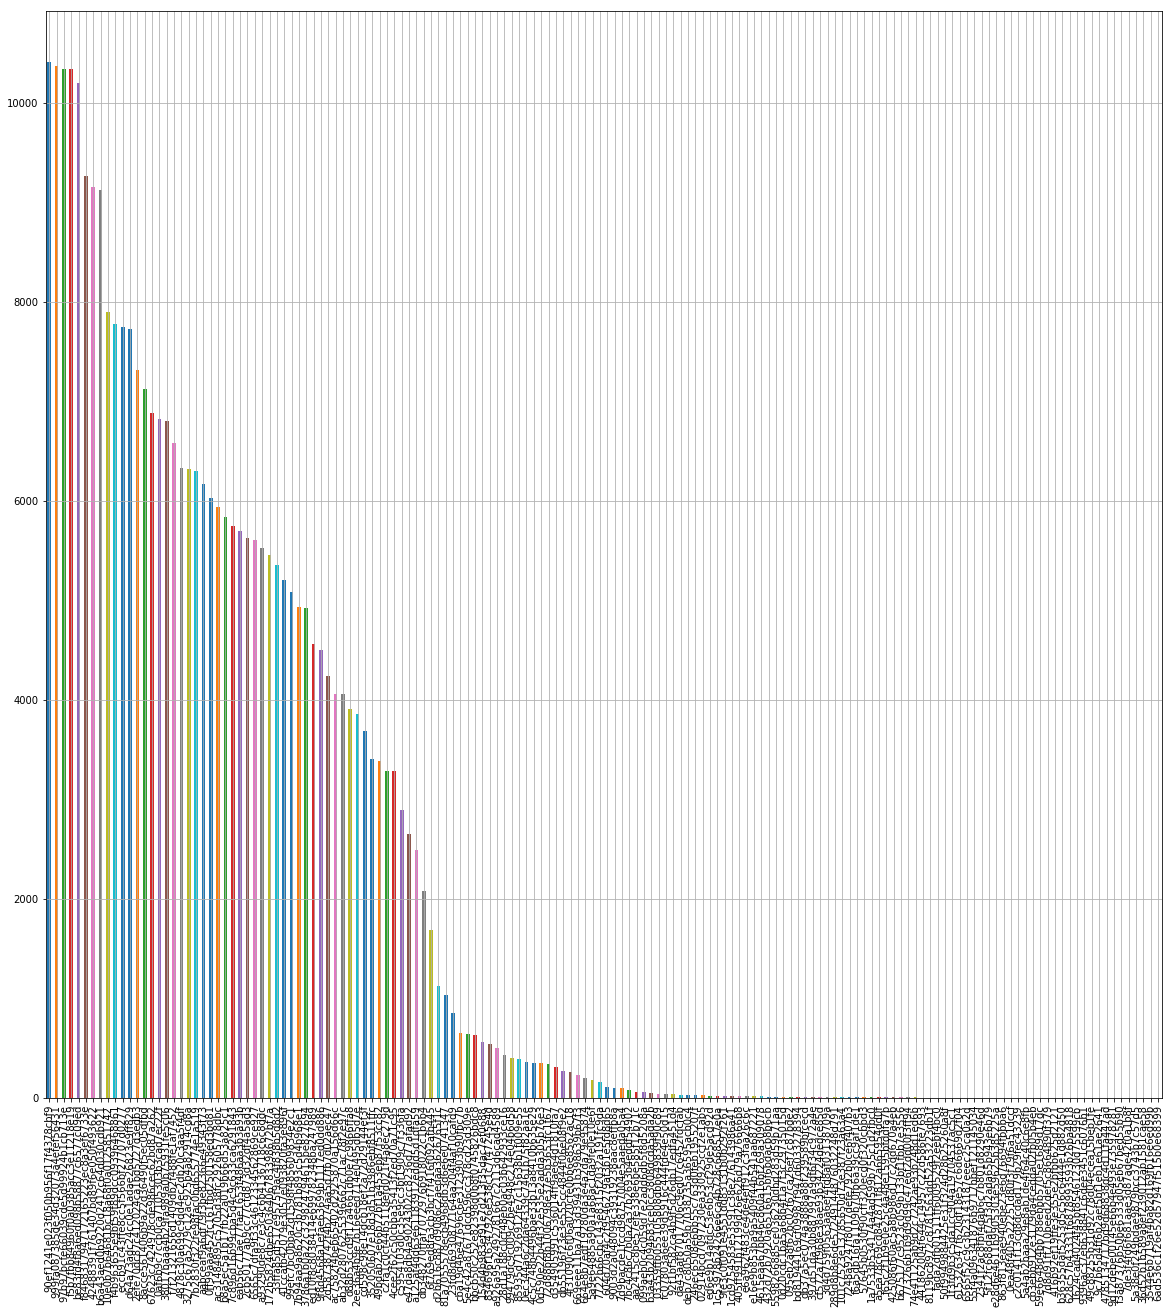

In [5]:
df['HASH'].value_counts().plot.bar(grid=True, figsize=(20,20))

Even though IQR is dominated by the mode, we can use this to highlight the threshold for abnormally small values by more or less inverting the interpretation of IQR as displayed by a box and whisker plot. That is, if it's *not* an outlier according to the box and whisker plot, then it's worth examining.

Looking at the graph, we can estimate that the WAPs worth examining talk less than 500 times during the collection period

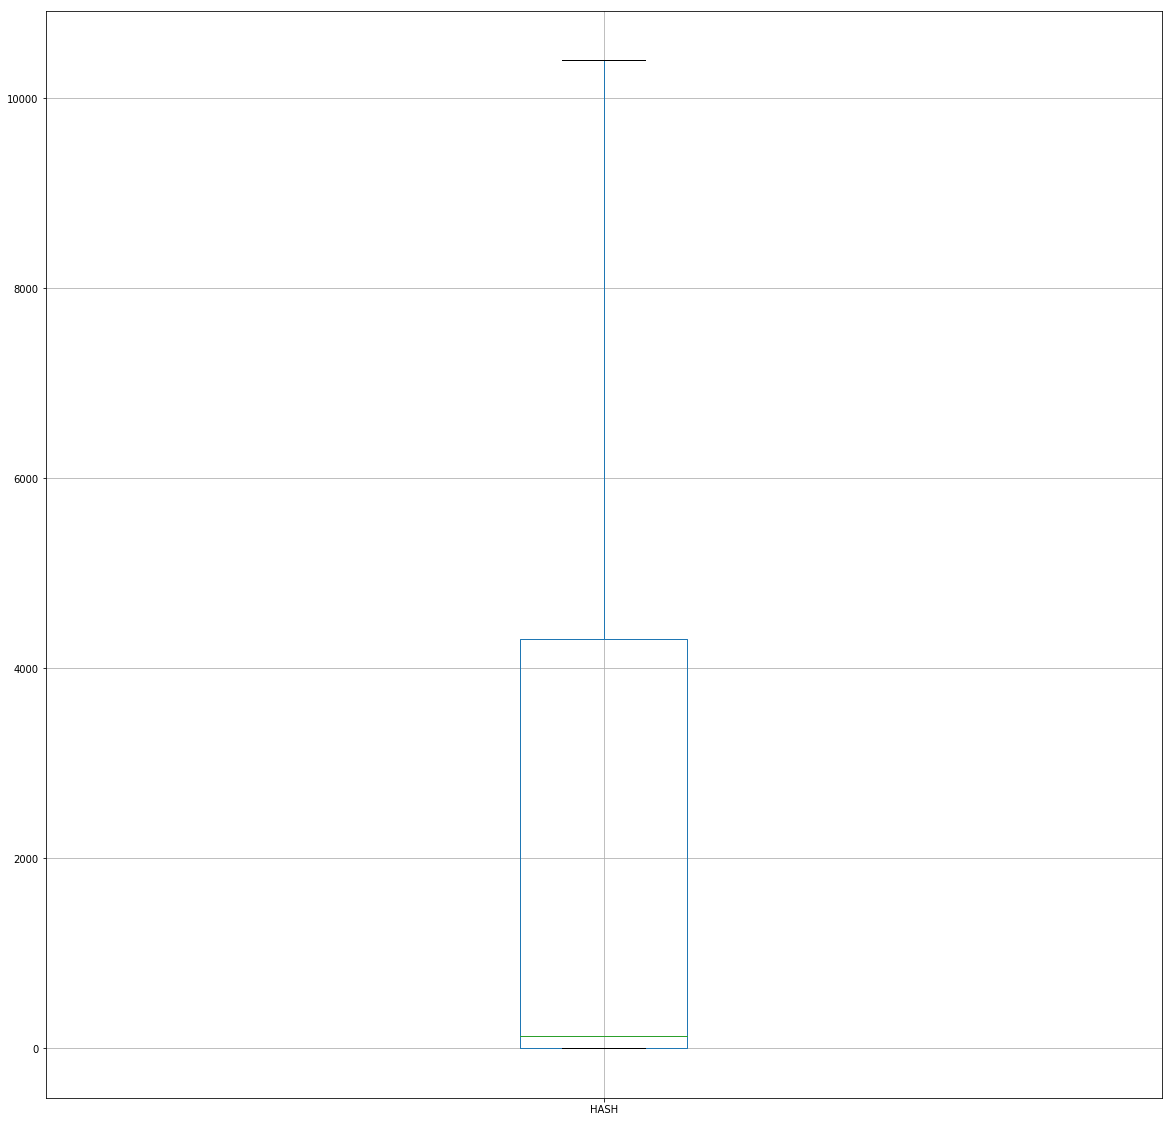

In [6]:
df['HASH'].value_counts().plot.box(grid=True, figsize=(20,20))

# Building a PivotFrame

Now we build a new dataframe, "counts" that is a pivot table given our hashes, count the number of frames seen. Later analysis will dig into unknown OUIs and guessing different types of devices based off SSID

In [7]:
counts = df['HASH'].value_counts().to_frame()
company_dict = {key:value for key, value in zip(df.HASH, df.CO)}
oui_dict = {key:value for key, value in zip(df.HASH, df.OUI)}
counts.columns = ['COUNT']
counts['CO'] = [company_dict[h] for h in counts.index]
counts['OUI'] = [oui_dict[h] for h in counts.index]

The following section is our eyeball estimation of delineation between transient and stationary WAPs, roughly 5500 records. Set the attribute "label" to 1 if estimated to be stationary, 0 if transient

In [8]:
mask_off = counts['COUNT'] >= 5500
counts['label'] = 0
counts.loc[mask_off, 'label'] = 1
display(counts.loc[(counts['COUNT'] < 5500) & (counts['CO'] == "UNKNOWN")].sort_values(by='OUI').head())

,COUNT,CO,OUI,label
c5954103d0c35e9cc3bf1909c7f336fa,2890,UNKNOWN,02:71:47,0
154d4b983ef91e7d213f35dac7ef0688,559,UNKNOWN,02:71:47,0
db348270ffaf7072976b918022c1b6b4,2083,UNKNOWN,12:62:E5,0
7d8d91ff710beed2def5c8664890f379,1,UNKNOWN,12:98:C3,0
289d8b8e6de57249144876032248d791,8,UNKNOWN,22:AD:56,0


# Digging into Pattern of Life (PoL) Information

We will take one SSID as an example for the following section

In [9]:
specific_df = df.loc[df['HASH'] == 'db348270ffaf7072976b918022c1b6b4']
specific_df.head()

,Unnamed: 0,RSSI,CHANNEL,SENSOR,EPOCH,OUI,HASH,CO,MONTH,DAY,HOUR,MIN,SEC,MIN_OF_DAY
56,56,0,11,Pi3B,1.559696e+09,12:62:E5,db348270ffaf7072976b918022c1b6b4,UNKNOWN,6,4,20,47,44,1220
106,106,0,11,Pi3B,1.559696e+09,12:62:E5,db348270ffaf7072976b918022c1b6b4,UNKNOWN,6,4,20,48,54,1220
164,164,0,11,Pi3B,1.559696e+09,12:62:E5,db348270ffaf7072976b918022c1b6b4,UNKNOWN,6,4,20,50,3,1220
226,226,0,11,Pi3B,1.559696e+09,12:62:E5,db348270ffaf7072976b918022c1b6b4,UNKNOWN,6,4,20,51,13,1220
279,279,0,11,Pi3B,1.559696e+09,12:62:E5,db348270ffaf7072976b918022c1b6b4,UNKNOWN,6,4,20,52,23,1220


The below heatmap plots the number of records seen over the course of a hour where the X axis is the timeststamp's minute and the Y axis is the timestamp's second. The dispersion tells us roughly when we see this WAP active in the area of operation. This particular WAP seems to most frequently send a beacon frame between seconds 10 and 20, as well as secondsd 40 to 50.

(0, 60)

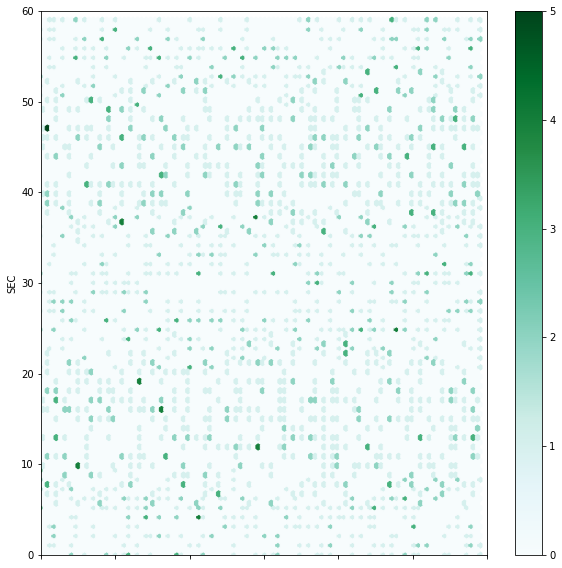

In [10]:
ax3 = specific_df.plot.hexbin(x='MIN', y='SEC', figsize=(10,10))
ax3.set_xlim(0,60)
ax3.set_ylim(0,60)

# Making a Pattern of Life fingerprint

Here we will make a pattern of life fingerprint for a particular WAP based on it's activity levels for a particular minute of the day. We will create an array of size 1441 - the first position stores the hash of the WAP, and the others represent the normalized number of records seen for that particular minute in the day. 

In [11]:
def make_print(d):
    fingerprint = [0.0 for x in range(24 * 60)]
    if d is not None and len(d) > 0:
        max_value = max(d.values())
        for port in d.keys():
            fingerprint[port] = d[port]/max_value
    return fingerprint

In [12]:
all_hashs = df["HASH"].unique()
fingerprints = list()
for h in all_hashs:
    h_dict = dict(df.loc[df['HASH'] == h]['MIN_OF_DAY'].value_counts())
    fingerprints.append([h]+make_print(h_dict))
print_frame = pd.DataFrame(fingerprints)
display(print_frame.head())    

,0,1,2,3,4,5,6,7,8,9,...,1431,1432,1433,1434,1435,1436,1437,1438,1439,1440
0,0af6b9c7ccb0ca7105303b3cad7ec22f,0.962733,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,172b5824dbe65036406783398672bf7a,0.729630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ac31484895c5705d38fc292605778dbc,0.921986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,eab56c71ae77fae1653f486aa3b3a93b,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,f4b963655e9bf59f89dcc09396468861,0.997230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Principal Component Analysis visualization

Now we want to see which WAPs have similar PoL based off their minutes of day pattern of life. Directly comparing minutes individually will yield a pattern of life comparison only for that specific minute, and different WAPs are hypothesized to have similar patterns but occur at different times. Thus we need to find a way to reduce the unimportant attributes and summarize the ones that truly capture the WAPs PoL. 

Enter Principal Component Analysis (PCA) - a dimensionality reduction technique common in machine learning. PCA effectively puts all given attributes into a "melting pot" and distills the most important attributese into a summarized variable - what is called a principal component (PC). For ease of visualization, we will start with 2 PCs.  

In [13]:
pca = PCA(n_components=2)
x = print_frame.iloc[:,1:].values
principalComponenets=pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponenets, columns = ['pc1','pc2'])
display(principalDf.head())

,pc1,pc2
0,2.375038,-0.248592
1,2.190264,-0.130009
2,2.367419,-0.157069
3,2.111061,0.059823
4,2.465036,-0.155237


Now we enrich the principal component dataframe with the WAP's associated hash and previously estimated label of transient (0) or stationary (1)

In [14]:
final1_df = pd.concat([principalDf,print_frame[0]],axis=1)
final1_df = final1_df.rename(columns={0:'target'})
counts['HASH'] = counts.index
hold_df = final1_df.merge(counts, left_on='target', right_on='HASH')
final_df = hold_df[['HASH','pc1','pc2','label']]
display(final_df.head())

,HASH,pc1,pc2,label
0,0af6b9c7ccb0ca7105303b3cad7ec22f,2.375038,-0.248592,1
1,172b5824dbe65036406783398672bf7a,2.190264,-0.130009,0
2,ac31484895c5705d38fc292605778dbc,2.367419,-0.157069,1
3,eab56c71ae77fae1653f486aa3b3a93b,2.111061,0.059823,1
4,f4b963655e9bf59f89dcc09396468861,2.465036,-0.155237,1


Finally, we plot the WAPs with the two PC values as our X and Y axis

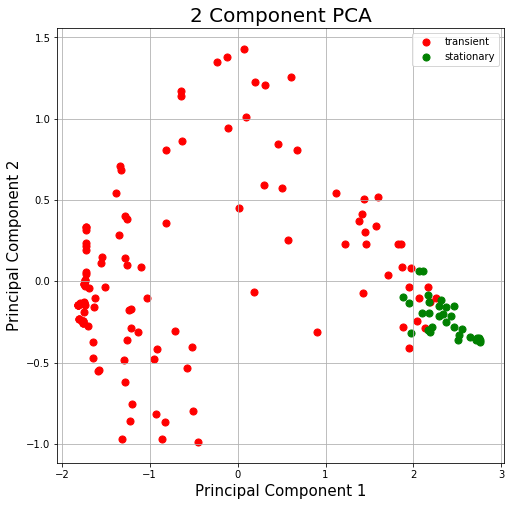

In [15]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = final_df['label'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'pc1']
               , final_df.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 50)


legend = ['transient','stationary']
ax.legend(legend)
ax.grid()

As you can see, there is a very distinct seperation between transient and stationary, validating our hypothesis that we can use machine learning techniques to distinguish between transient and stationary WAPs based off observations throughout the day. The next steps for us is to verify the number of PCs used that will explain a satisfactory amount of variance (model validation) and then applying a classifier (logistic regression or support vector machine) that will do the actual prediction for the labels of transient or stationary 

------------------------------------------------------------